## Some Common Imports

In [1]:
#!pip install -r  requirements.txt

In [1]:
import os
import cv2
import random

import torch 
from torch import nn 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


import utils 
import create_custom_dataset as cd
import create_custom_model as model
import train_model as t
import test_model

# Clear CUDA cache
torch.cuda.empty_cache()

# Set the seed for the random number generator in PyTorch
torch.manual_seed(42)

## GPU details

In [2]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

Device: cuda
Number of CPU cores: 8
GPU name: NVIDIA RTX A4000


## Setup Configurations

In [3]:
# Specifies the path to the CSV file containing the data
ORGINAL_PATH = os.path.join(os.getcwd(),'dataframes/df.csv')
TRAIN_PATH = os.path.join(os.getcwd(),'dataframes/train.csv')
TEST_PATH = os.path.join(os.getcwd(),'dataframes/test.csv')
VALID_PATH = os.path.join(os.getcwd(),'dataframes/valid.csv')


# Set up row and column number 
NUM_ROWS = 1
NUM_COLS = 10
NUM_IMAGES = 8

# Specifies the batch size 
BATCH_SIZE = 32 

# Specifies the number of classes
NUM_CLASSES = 2


# Specifies loss function
LOSS_FUNCTION = nn.CrossEntropyLoss()

# Specifies the number of training epochs
EPOCHS = 5

In [4]:
csv_file = ORGINAL_PATH
train_csv = TRAIN_PATH
valid_csv = TEST_PATH
test_csv = VALID_PATH

utils.split_csv(csv_file, train_csv, valid_csv, test_csv)

CSV file split into train, validation, and test sets successfully.


In [5]:
# Read the CSV file into a DataFrame using the specified file path
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
val_df = pd.read_csv(VALID_PATH)

# Display the first few rows of the DataFrame
train_df.head()

,Image path,Label
0,/notebooks/chest_xray/NORMAL/IM-0668-0001.jpeg,NORMAL
1,/notebooks/chest_xray/PNEUMONIA/person78_bacte...,PNEUMONIA
2,/notebooks/chest_xray/PNEUMONIA/person17_bacte...,PNEUMONIA
3,/notebooks/chest_xray/NORMAL/IM-0540-0001.jpeg,NORMAL
4,/notebooks/chest_xray/PNEUMONIA/person1449_vir...,PNEUMONIA


## Show Distribution of labels in each dataframe

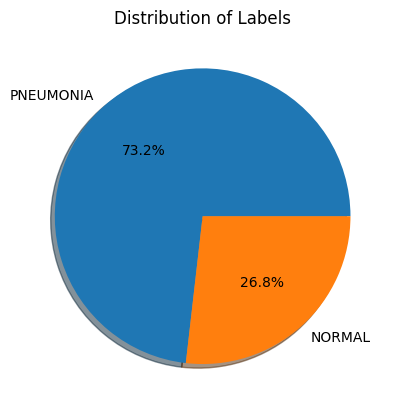

In [6]:
# train
utils.show_labels_distribution(train_df)

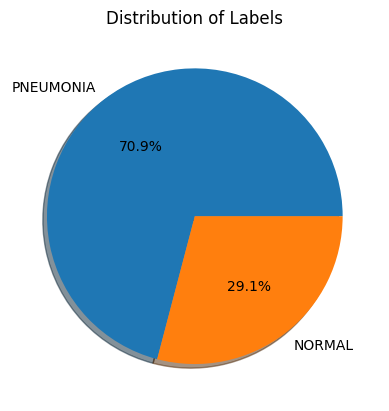

In [7]:
# val
utils.show_labels_distribution(val_df)

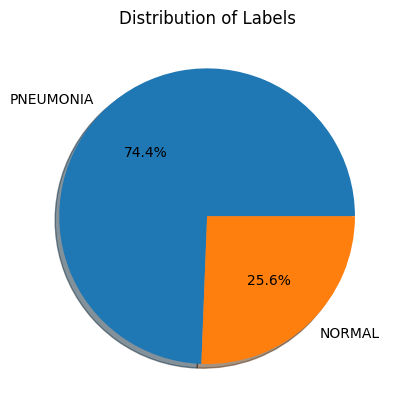

In [8]:
# test
utils.show_labels_distribution(test_df)

## Create Custom Dataset

In [6]:
# load the datasets
trainset = cd.ChestXRay(train_df,augmentations=cd.get_train_augs())
validset = cd.ChestXRay(val_df,augmentations=cd.get_valid_augs())
testset = cd.ChestXRay(test_df,augmentations=cd.get_valid_augs())


In [7]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"Size of Testset : {len(testset)}")

Size of Trainset : 3513
Size of Validset : 1172
Size of Testset : 1171


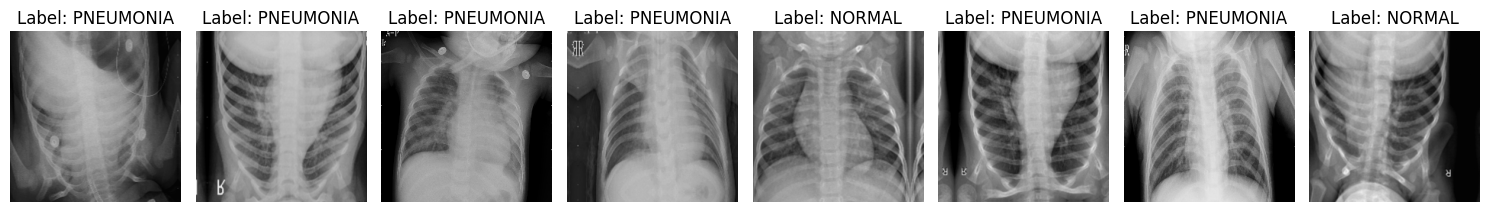

In [8]:
# show some images
utils.show_multiple_images(trainset, NUM_IMAGES)

## Load dataset into batches

In [9]:
# initlize sampler
train_sampler = cd.create_weighted_sampler(trainset)


100%|██████████| 3513/3513 [00:47<00:00, 74.47it/s] 


In [10]:
# Create a data loader for the datasets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,sampler=train_sampler,num_workers=4)
val_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [11]:
print(f"total no. of batches in trainloader : {len(train_loader)}")
print(f"total no. of batches in validloader : {len(val_loader)}")
print(f"total no. of batches in testloader : {len(test_loader)}")

total no. of batches in trainloader : 110
total no. of batches in validloader : 37
total no. of batches in testloader : 37


In [12]:
for image , _ in train_loader:
    print(f"One batch image shape : {image.shape}")
    break


One batch image shape : torch.Size([32, 224, 224, 3])


## Create Classification Model

In [13]:
efficientnet_model = model.CustomModel(NUM_CLASSES)

Loaded pretrained weights for efficientnet-b0


In [14]:
efficientnet_model.to(device)

CustomModel(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

## Train and evaluate model

100%|██████████| 37/37 [00:03<00:00, 10.31it/s]


SAVED-MODEL
Epoch: 1 Train loss: 0.1941 Train accuracy: 0.9309 Valid loss: 1.2582 Valid accuracy: 0.7147


100%|██████████| 37/37 [00:03<00:00, 10.23it/s]


SAVED-MODEL
Epoch: 2 Train loss: 0.1283 Train accuracy: 0.9508 Valid loss: 0.2489 Valid accuracy: 0.9312


100%|██████████| 37/37 [00:03<00:00, 10.13it/s]


SAVED-MODEL
Epoch: 3 Train loss: 0.1055 Train accuracy: 0.9579 Valid loss: 0.2846 Valid accuracy: 0.9556


100%|██████████| 37/37 [00:03<00:00, 10.29it/s]


Epoch: 4 Train loss: 0.0936 Train accuracy: 0.9670 Valid loss: 0.2275 Valid accuracy: 0.9115


100%|██████████| 37/37 [00:03<00:00, 10.66it/s]


SAVED-MODEL
Epoch: 5 Train loss: 0.0856 Train accuracy: 0.9705 Valid loss: 0.0886 Valid accuracy: 0.9747
Best Validation Accuracy: 0.9747


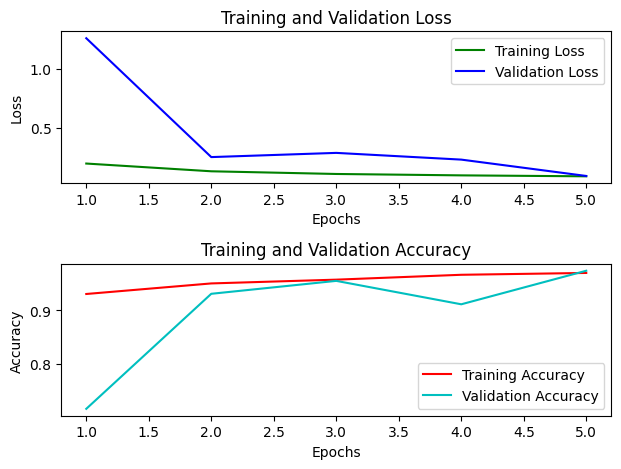

In [19]:
# Specifies optimizer and scheduler 
OPTIMIZER = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.1, patience=5, verbose=True)

trainer = t.Trainer(efficientnet_model, OPTIMIZER, SCHEDULER, device)
trainer.train_and_evaluate(EPOCHS, train_loader, val_loader, LOSS_FUNCTION)

## Inference

In [21]:
# load the saved model
efficientnet_model.load_state_dict(torch.load('./best_model.pt'))

<All keys matched successfully>

In [22]:
# init tester
tester = test_model.ImageClassifier()

In [23]:
# get the true labels and predected classes 
true_labels, predicted_classes = tester.predict(test_loader, efficientnet_model, device)

In [24]:
# print classification repoert
tester.print_classification_report(true_labels, predicted_classes)

              precision    recall  f1-score   support

      NORMAL       0.78      1.00      0.87       300
   PNEUMONIA       1.00      0.90      0.95       871

    accuracy                           0.93      1171
   macro avg       0.89      0.95      0.91      1171
weighted avg       0.94      0.93      0.93      1171



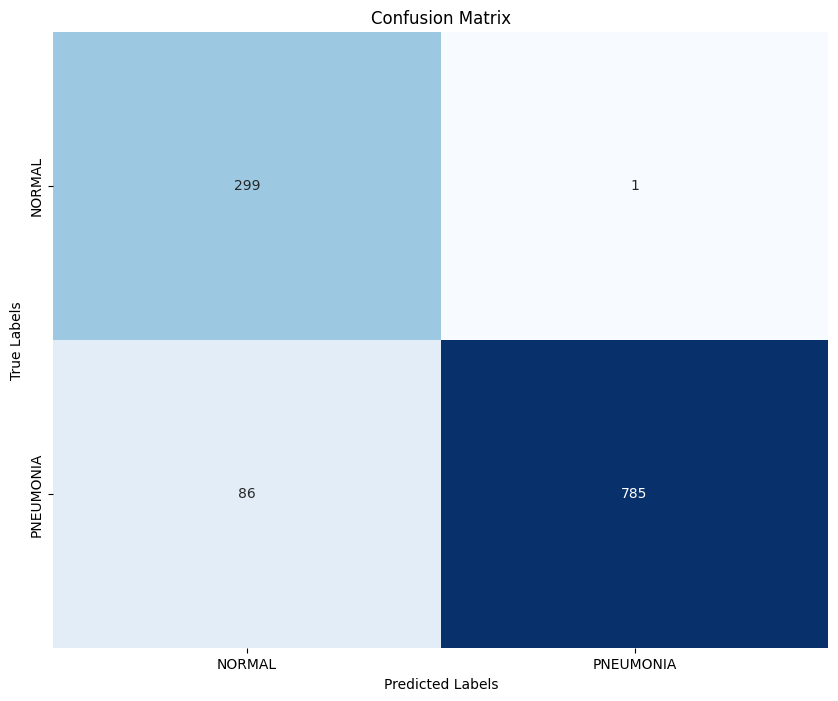

In [25]:
# plot confusion matrix
tester.plot_confusion_matrix(true_labels, predicted_classes)

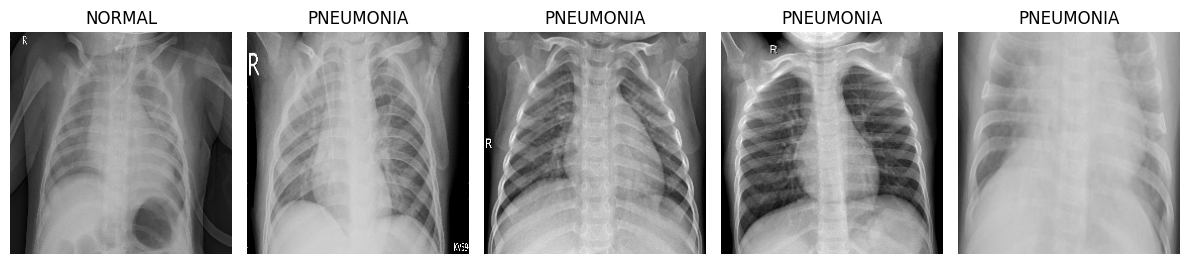

In [26]:
tester.display_predicted_images(test_loader, num_images=5)